
Welcome to your assignment this week!

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text.

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.



Run the following cell to load the packages you will need.

In [ ]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

# Build the model

Let's define a tokenizer and read the data from disk.

In [ ]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [ ]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [ ]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [ ]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [ ]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')


The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [ ]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [ ]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [ ]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](./imgs/text_generation.png)




**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [ ]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    ### START CODE HERE ###
    model = Sequential()
    model.add(Embedding(input_dim=total_words, output_dim=128, input_length=max_sequence_len-1))
    model.add(LSTM(128))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    ### END CODE HERE ###

#Print details of the model.
model = deep_fake_comment_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Now, let's start our training.

In [ ]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0648 - loss: 6.5783
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0722 - loss: 5.8723
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0801 - loss: 5.7138
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1071 - loss: 5.5186
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1137 - loss: 5.3972
Epoch 6/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1424 - loss: 5.1960
Epoch 7/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1535 - loss: 5.0135
Epoch 8/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1576 - loss: 4.9083
Epoch 9/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1766 - loss: 4.6686
Epoch 10/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1959 - loss: 4.5106
Epoch 11/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2054 - loss: 4.4144
Epoch 12/200
126/126 ━━━━━━━━━━━━━━━━━━

Let's plot details of our training.

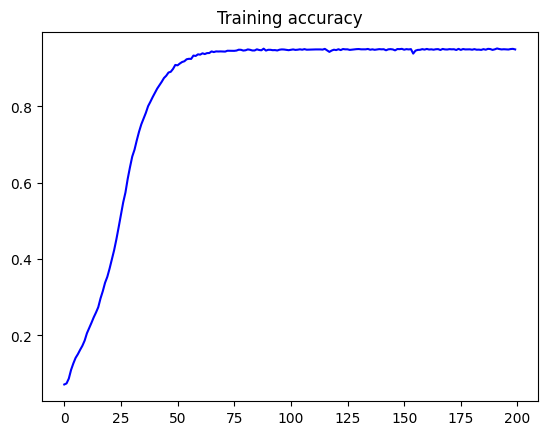

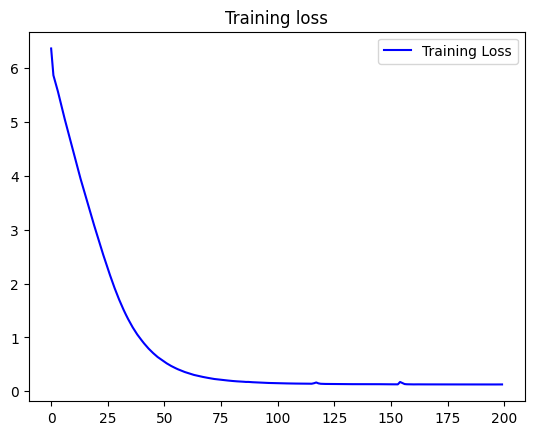

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](./imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`.

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before.



**Task 2**: Implement `generate()`.

***

In [ ]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    ### START CODE HERE ###
    next_words = 20
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == ".":
            break
        seed_text += " " + output_word
    return seed_text
    ### END CODE HERE ###


**Let's test it:**

In [ ]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))
print(generate("China has"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
COVID19 virus survives on surfaces for 7 days
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
COVID19 is the deadliest virus known to humans
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The usa is one of the covid19 virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/s

**Let's test it in an interactive mode:**

In [ ]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: in the america
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
in the america has far fewer covid19 deaths than new york 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [ ]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
    ### START CODE HERE ###
    next_words = 20
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        probas = model.predict(token_list)[0]
        predicted = np.random.choice(range(total_words), p=probas)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == ".":
            break
        seed_text += " " + output_word
    return seed_text
    ### END CODE HERE ###

**Let's test it in an interactive mode:**

In [ ]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate_sample(usr_input).split():
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: in america
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
in america has the sun for two hours kills the 2019 covid19 

# Generate your own text

Below, use you own data to generate content for a different application:  
In this case, im createing a fake news generator about news in the USA  
Datasets collected from: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data

In [ ]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('fakenews.txt', encoding='utf-8').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [ ]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  [" donald trump sends out embarrassing new year's eve message; this is disturbing", ' drunk bragging trump staffer started russian collusion investigation']
Size of the vocabulary =  1243
Example of our word index =  [('trump', 1), ('to', 2), ('the', 3), ('for', 4), ('a', 5), ('is', 6), (',', 7), ('in', 8), ('his', 9), ('and', 10)]


In [ ]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')

The entry  20  in 'input_sequences' is: 
[206, 395, 396, 397]
 and it corresponds to:
sheriff david clarke becomes 

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 206 395
 396 397]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ sheriff david clarke becomes ]


In [ ]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]

In [ ]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 206 395
 396 397]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 206 395
 396]
 and the following output:  397


In [ ]:
label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
model = deep_fake_comment_model()

In [ ]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0238 - loss: 6.9979
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0209 - loss: 6.5016
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0365 - loss: 6.3595
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0359 - loss: 6.1165
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0355 - loss: 5.9754
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0481 - loss: 5.8331
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0444 - loss: 5.7170
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0617 - loss: 5.4487
Epoch 9/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0556 - loss: 5.3854
Epoch 10/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0862 - loss: 5.1102
Epoch 11/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1021 - loss: 4.9719
Epoch 12/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy

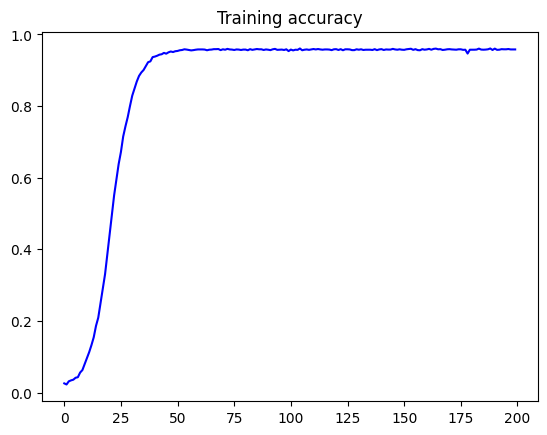

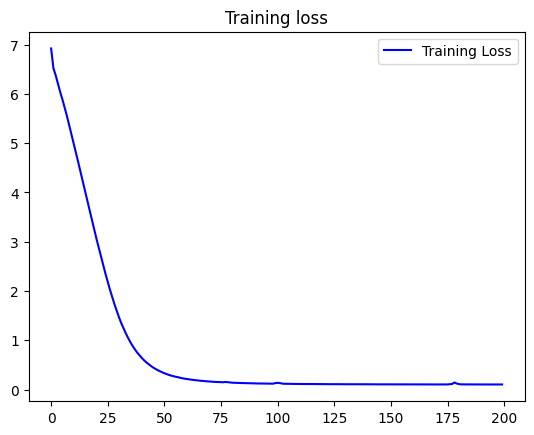

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
print(generate("Trump is"))
print(generate("Asian"))
print(generate("Biden"))
print(generate("Black"))
print(generate("Crime"))
print(generate("Watch this"))
print(generate("Breaking news"))
print(generate("Joe"))
print(generate("Today"))
print(generate("Tax"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Trump is throwing jared kushner under the bus over mueller indictments a 13 year old girl the baboon' heartless biden deaf hero
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Export your notebook to a pdf document

In [ ]:
# !jupyter nbconvert --to pdf "C:\Users\micha\Desktop\deakin stuff\deakintrimester3\SIT799 - Human Aligned\\task5.2\\5.2D - DeepFakeComments Generator.ipynb"

# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments.

Congratulations on finishing this notebook!

